In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE


In [28]:
data = pd.read_csv('C:/Users/91903/Desktop/credit-card-fraud-detection/data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
print("Dataset shape:", data.shape)
print("Class counts:\n", data['Class'].value_counts())
print("Fraud percentage:\n", data['Class'].value_counts(normalize=True) * 100)

Dataset shape: (284807, 31)
Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage:
 Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [30]:
if 'Amount' in data.columns:
    data['NormalizedAmount'] = StandardScaler().fit_transform(data[['Amount']])
    data.drop(columns=[col for col in ['Time', 'Amount'] if col in data.columns], inplace=True)

In [31]:
if 'Class' in data.columns:
    cols = [c for c in data.columns if c != 'Class']
    cols.append('Class')
    data = data[cols]

In [32]:
# Simulate transaction index and spending pattern
data['TxnIndex'] = np.arange(len(data))
data['RollingAvgAmount'] = data['NormalizedAmount'].rolling(window=10).mean().fillna(0)

In [33]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [34]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("Class balance after SMOTE:")
print(pd.Series(y_train_bal).value_counts())

Class balance after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [35]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC: {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\91903\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Logistic Regression Results]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.91      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.95      0.61     56962
weighted avg       1.00      0.99      0.99     56962



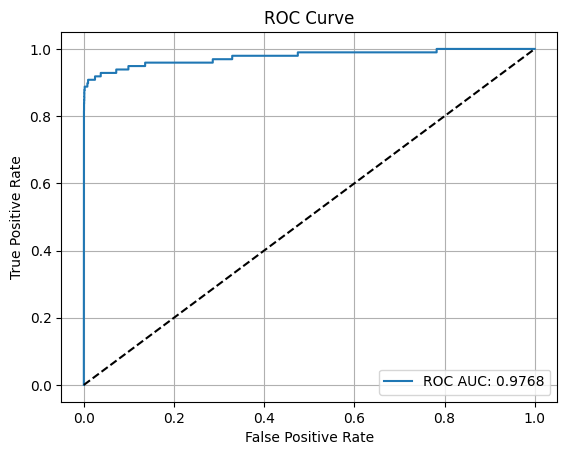

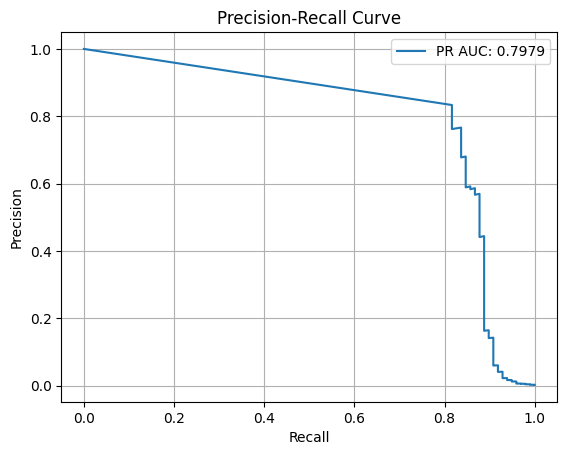

In [36]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_bal, y_train_bal)

print("[Logistic Regression Results]")
evaluate_model(log_model, X_test, y_test)

[Random Forest Results]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



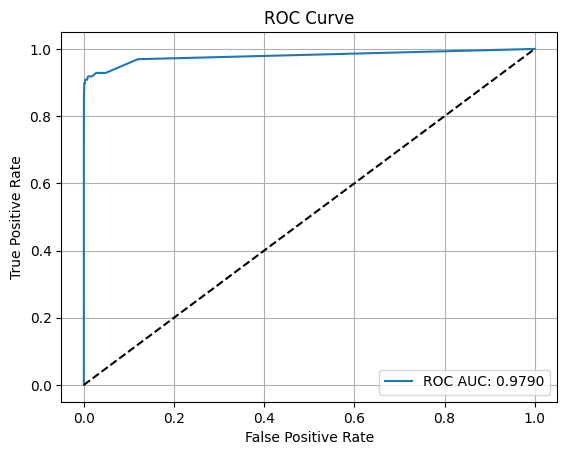

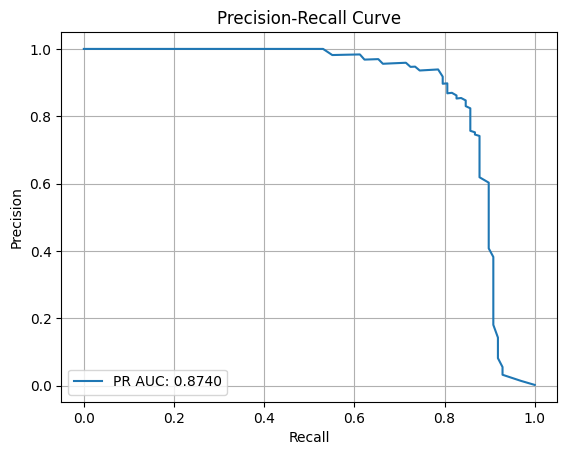

In [37]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)

print("[Random Forest Results]")
evaluate_model(rf_model, X_test, y_test)

C:\Users\91903\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:20:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[XGBoost Results]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.88      0.85        98

    accuracy                           1.00     56962
   macro avg       0.91      0.94      0.93     56962
weighted avg       1.00      1.00      1.00     56962



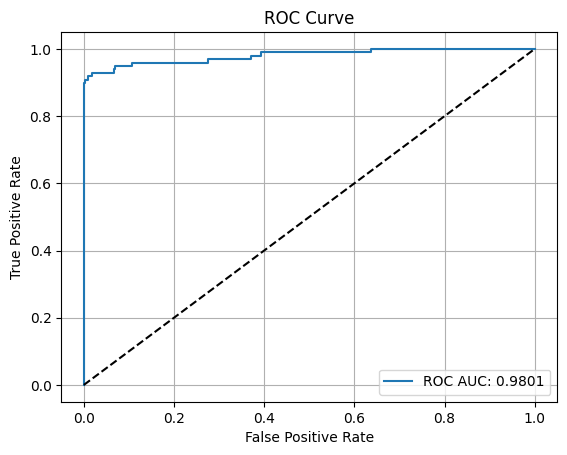

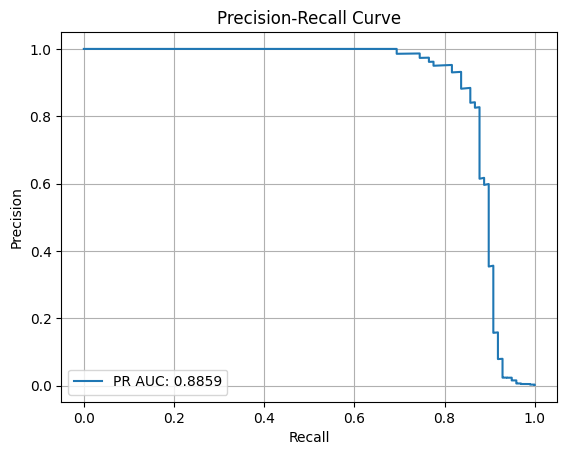

In [38]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

print("[XGBoost Results]")
evaluate_model(xgb_model, X_test, y_test)

C:\Users\91903\AppData\Local\Temp\ipykernel_26084\3420726756.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances[:10], y=top_features[:10], palette='coolwarm')


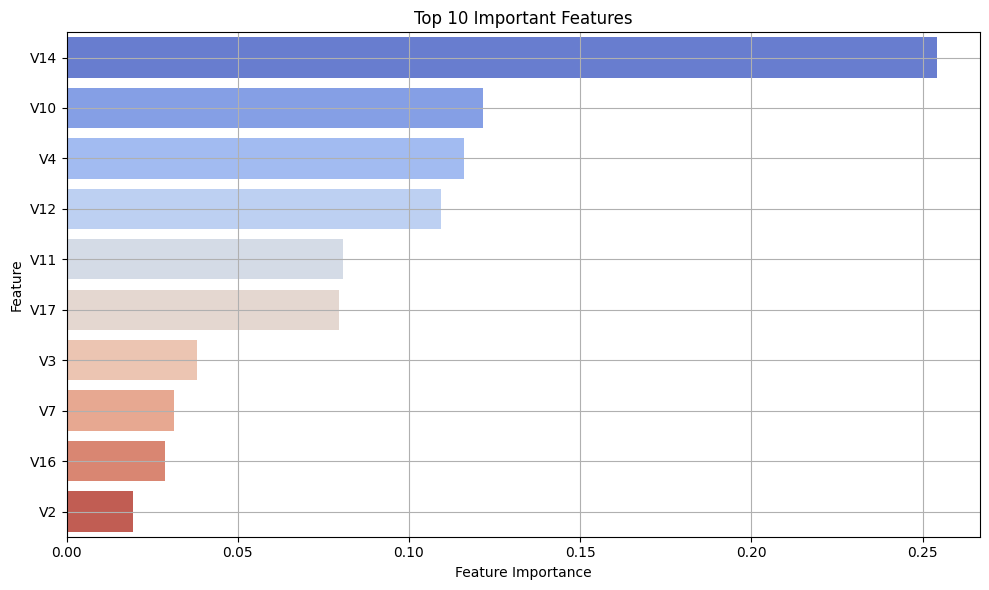

In [39]:
importances = rf_model.feature_importances_
feature_names = X_train_bal.columns

sorted_idx = np.argsort(importances)[::-1]
top_features = feature_names[sorted_idx]
top_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances[:10], y=top_features[:10], palette='coolwarm')
plt.title('Top 10 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(True)
plt.show()